This code file 

In [ ]:
#%cd \path\to\replication

C:\Users\maxmo\Dropbox\GDS\Dissertation\replication


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

INPATH = r"data\full_table_v2.csv"
STATS_PATH = r"data\city_stats.csv"
TADDY_PATH = r"data\taddy_results.csv"
CENTRALITIES_PATH =r"data\total_centrality.csv"

df = pd.read_csv(INPATH)
taddy = pd.read_csv(TADDY_PATH)

df.columns
taddy.columns

Index(['master_id', 'year', 'forward', 'backward', 'taddy'], dtype='object')

In [3]:
df = pd.merge(df, taddy, on='master_id', how='left')

# Create city_name column that removes all numbers from city names
df['city_name'] = df['city'].str.replace(r'\d+', '', regex=True)

In [4]:
df.head()


,master_id,artist_id,genre,style,data_quality_y,year_x,title,recorded_id,latitude,longitude,...,member_ids,artist_name,artist_info_data_quality,new_style_1,novel_style_combo_count,year_y,forward,backward,taddy,city_name
0,130,3863.0,Electronic,Electro,0,1983,Clear,343680.0,42.297893,-83.728004,...,"['1102', '465878', '1149437', '1329510', '1997...",Cybotron,0.0,0,0,1983.0,0.010262,0.002873,3.572209,Ann Arbor
1,130,3863.0,Hip Hop,Electro,0,1983,Clear,343680.0,42.297893,-83.728004,...,"['1102', '465878', '1149437', '1329510', '1997...",Cybotron,0.0,0,0,1983.0,0.010262,0.002873,3.572209,Ann Arbor
2,133,3863.0,Electronic,Electro,0,1983,Enter,343680.0,42.297893,-83.728004,...,"['1102', '465878', '1149437', '1329510', '1997...",Cybotron,0.0,0,0,1983.0,0.041901,0.011420,3.669206,Ann Arbor
3,133,3863.0,Electronic,Synth-pop,0,1983,Enter,343680.0,42.297893,-83.728004,...,"['1102', '465878', '1149437', '1329510', '1997...",Cybotron,0.0,0,0,1983.0,0.041901,0.011420,3.669206,Ann Arbor
4,158,1282.0,Electronic,Trance,1,2000,Eugina,269784.0,51.507446,-0.127765,...,"['39118', '444336']",Salt Tank,0.0,0,0,2000.0,0.002393,0.003150,0.759620,London


In [5]:
df = df[df['taddy'] != 99]

# Update city_name column after cleaning
df['city_name'] = df['city'].str.replace(r'\d+', '', regex=True)

city_master_counts = df.groupby('city')['master_id'].nunique()
filtered_cities = city_master_counts[city_master_counts >= 300].index

# Calculate average taddy for cities with at least 200 master_ids
avg_taddy_by_city = (
    df[df['city'].isin(filtered_cities)]
    .groupby('city')['taddy']
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# Convert to list
avg_taddy_by_city_list = avg_taddy_by_city.reset_index().values.tolist()
pd.set_option('display.max_rows', None)
avg_taddy_by_city_list

[['Tampa', 2.3923204253045776],
 ['Newcastle', 1.8474097141703427],
 ['Leeds', 1.8418000065609212],
 ['Auckland', 1.7489004808443565],
 ['Manchester2', 1.7410348508798448],
 ['Evanston', 1.686112217917894],
 ['Liverpool2', 1.6853791489542185],
 ['DÌùsseldorf', 1.6776474774161696],
 ['Alexandria2', 1.6747754990218686],
 ['Chicago', 1.668625020541398],
 ['Sheffield', 1.5814630259650158],
 ['Edinburgh', 1.5455851129940459],
 ['Long Beach', 1.540555028831388],
 ['Dortmund', 1.5344455062150955],
 ['Kingston1', 1.50413939778639],
 ['Seattle', 1.4841388923470504],
 ['Philadelphia', 1.472393446270809],
 ['San Jose3', 1.4660931163897308],
 ['Brussels', 1.4478461990042404],
 ['Goteborg', 1.4149697183121037],
 ['San Mateo', 1.399777238402525],
 ['Bristol2', 1.375811286090744],
 ['Irvine', 1.3730128960802772],
 ['Newark', 1.3665380217755325],
 ['Essen', 1.3628376006281426],
 ['Turin', 1.3546971906902474],
 ['Cleveland', 1.34961038829426],
 ['Washington, D.C.', 1.3490994982019782],
 ['Milan', 1.346

Figure 7

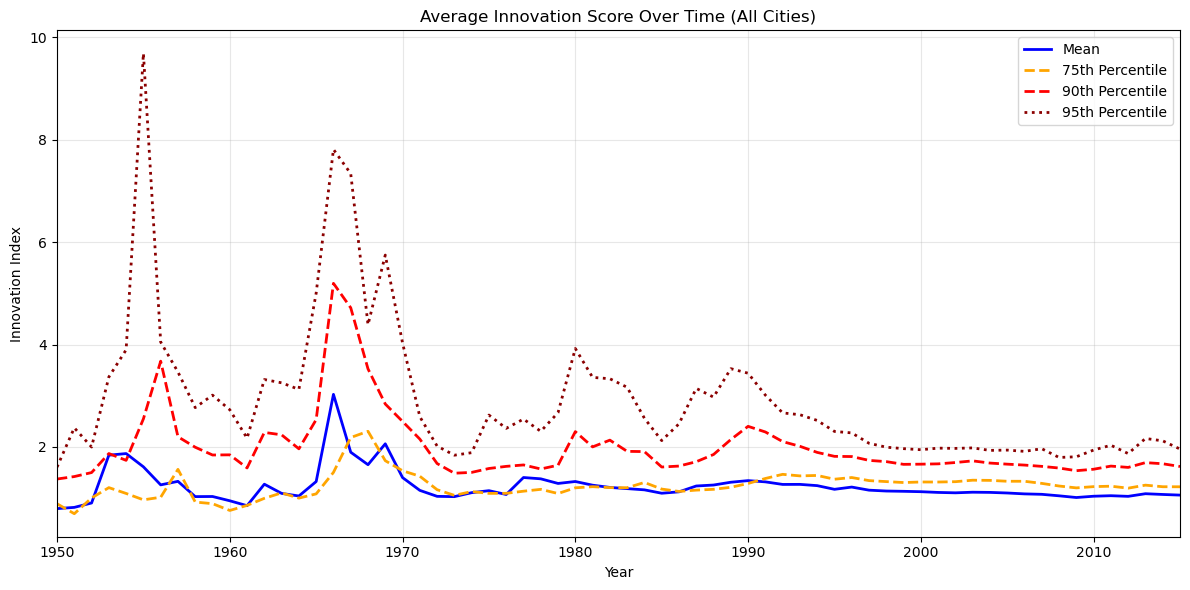

In [6]:
# Calculate average taddy scores by year across all cities
yearly_avg_taddy = df[df['taddy'] != 99].groupby('year_x')['taddy'].mean().reset_index()

# Calculate percentiles by year
yearly_percentiles = df[df['taddy'] != 99].groupby('year_x')['taddy'].agg([
    'mean', 
    lambda x: x.quantile(0.75), 
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95)
]).reset_index()
yearly_percentiles.columns = ['year_x', 'mean', 'p75', 'p90', 'p95']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(yearly_percentiles['year_x'], yearly_percentiles['mean'], linewidth=2, color='blue', label='Mean')
plt.plot(yearly_percentiles['year_x'], yearly_percentiles['p75'], linewidth=2, color='orange', linestyle='--', label='75th Percentile')
plt.plot(yearly_percentiles['year_x'], yearly_percentiles['p90'], linewidth=2, color='red', linestyle='--', label='90th Percentile')
plt.plot(yearly_percentiles['year_x'], yearly_percentiles['p95'], linewidth=2, color='darkred', linestyle=':', label='95th Percentile')
plt.xlabel('Year')
plt.ylabel('Innovation Index')
plt.title('Average Innovation Score Over Time (All Cities)')
plt.grid(True, alpha=0.3)
plt.xlim(1950, 2015)
plt.legend()
plt.tight_layout()
plt.show()

#save to discogs/output

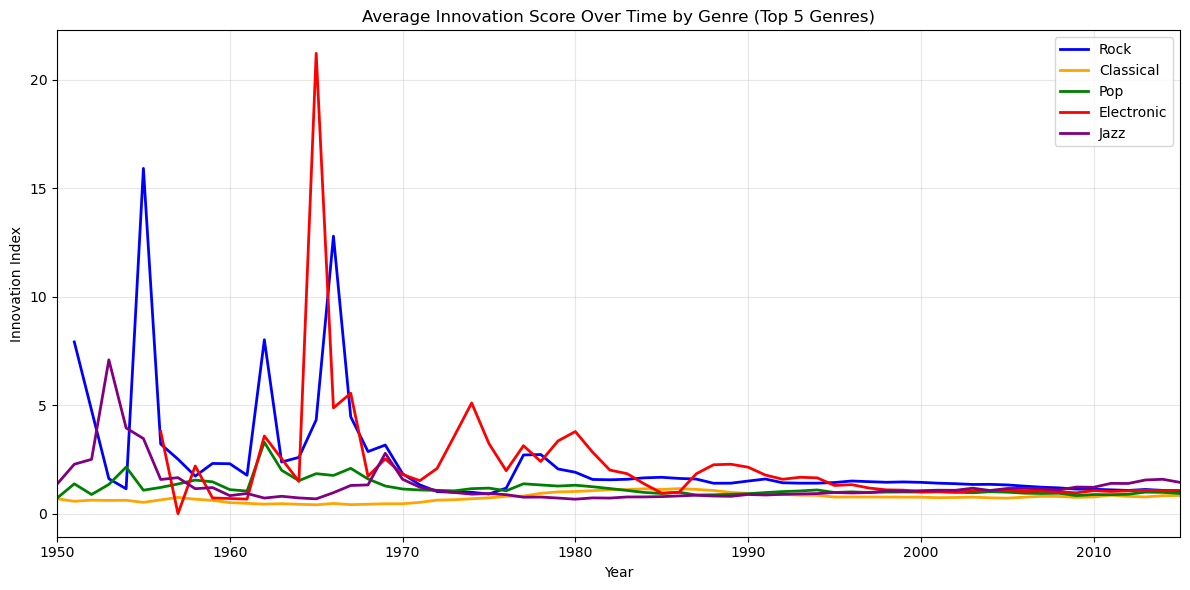

Top 5 genres by count: ['Rock', 'Classical', 'Pop', 'Electronic', 'Jazz']


In [7]:
# Calculate average taddy scores by year for top 5 genres
genre_counts = df['genre'].value_counts()
top_5_genres = genre_counts.head(5).index.tolist()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each genre separately
colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, genre in enumerate(top_5_genres):
    genre_data = df[(df['genre'] == genre) & (df['taddy'] != 99)]
    yearly_genre_taddy = genre_data.groupby('year_x')['taddy'].mean().reset_index()
    
    plt.plot(yearly_genre_taddy['year_x'], yearly_genre_taddy['taddy'], 
             linewidth=2, color=colors[i], label=genre)

plt.xlabel('Year')
plt.ylabel('Innovation Index')
plt.title('Average Innovation Score Over Time by Genre (Top 5 Genres)')
plt.grid(True, alpha=0.3)
plt.xlim(1950, 2015)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Top 5 genres by count: {top_5_genres}")

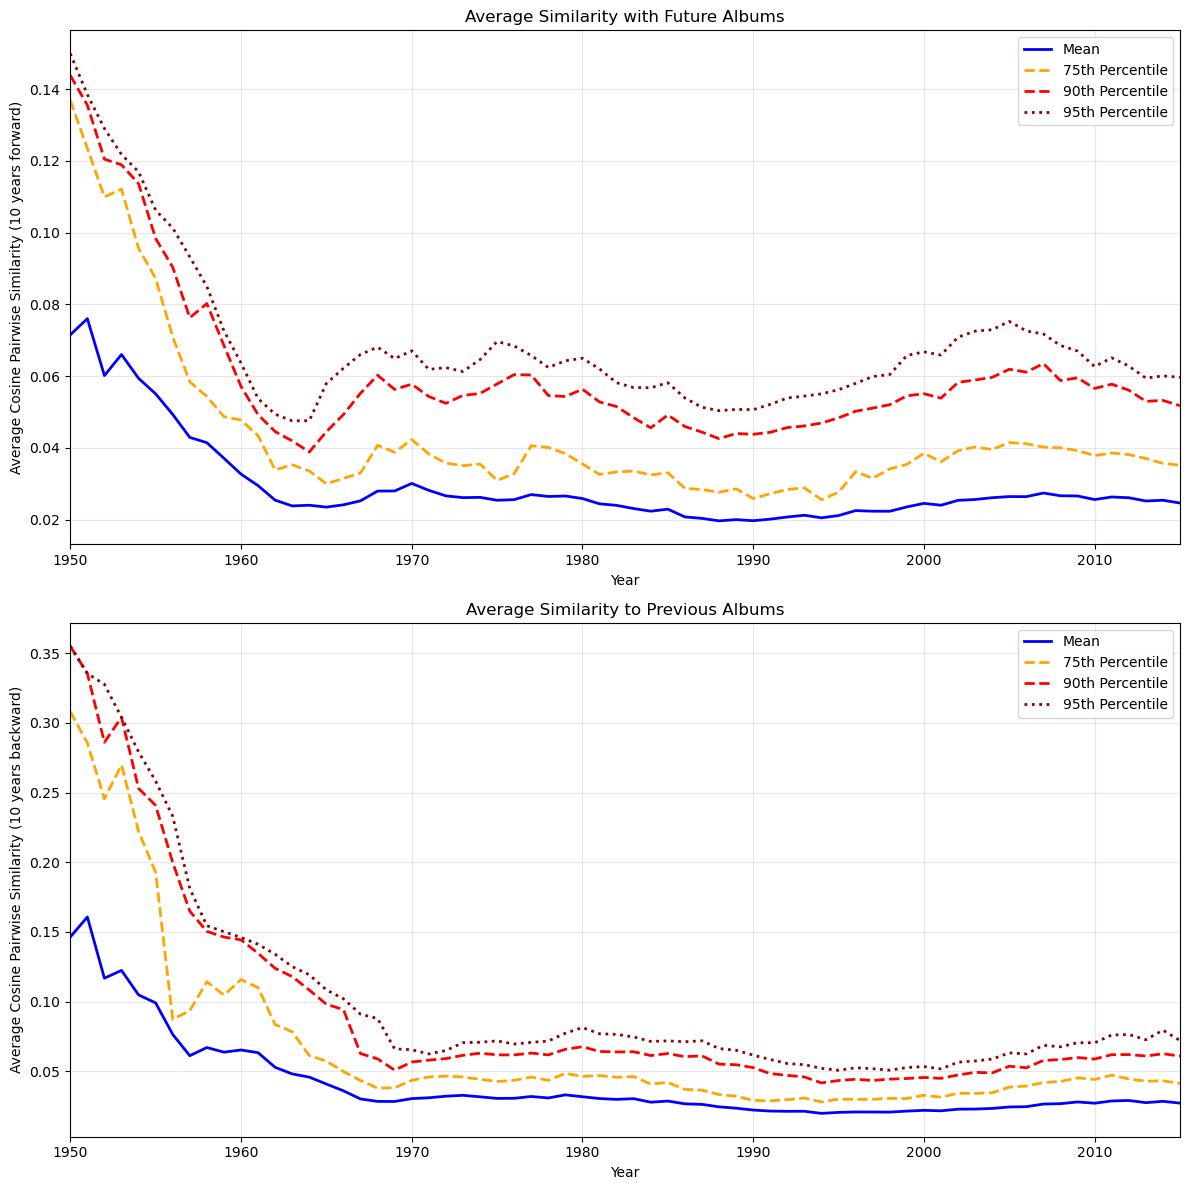

In [8]:
# Calculate forward scores by year across all cities
yearly_forward = df[df['forward'].notna()].groupby('year_x')['forward'].agg([
    'mean', 
    lambda x: x.quantile(0.75), 
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95)
]).reset_index()
yearly_forward.columns = ['year_x', 'mean', 'p75', 'p90', 'p95']

# Calculate backward scores by year across all cities
yearly_backward = df[df['backward'].notna()].groupby('year_x')['backward'].agg([
    'mean', 
    lambda x: x.quantile(0.75), 
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95)
]).reset_index()
yearly_backward.columns = ['year_x', 'mean', 'p75', 'p90', 'p95']

# Create subplots for forward and backward
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Forward plot
ax1.plot(yearly_forward['year_x'], yearly_forward['mean'], linewidth=2, color='blue', label='Mean')
ax1.plot(yearly_forward['year_x'], yearly_forward['p75'], linewidth=2, color='orange', linestyle='--', label='75th Percentile')
ax1.plot(yearly_forward['year_x'], yearly_forward['p90'], linewidth=2, color='red', linestyle='--', label='90th Percentile')
ax1.plot(yearly_forward['year_x'], yearly_forward['p95'], linewidth=2, color='darkred', linestyle=':', label='95th Percentile')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Cosine Pairwise Similarity (10 years forward)')
ax1.set_title('Average Similarity with Future Albums')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1950, 2015)
ax1.legend()

# Backward plot
ax2.plot(yearly_backward['year_x'], yearly_backward['mean'], linewidth=2, color='blue', label='Mean')
ax2.plot(yearly_backward['year_x'], yearly_backward['p75'], linewidth=2, color='orange', linestyle='--', label='75th Percentile')
ax2.plot(yearly_backward['year_x'], yearly_backward['p90'], linewidth=2, color='red', linestyle='--', label='90th Percentile')
ax2.plot(yearly_backward['year_x'], yearly_backward['p95'], linewidth=2, color='darkred', linestyle=':', label='95th Percentile')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Cosine Pairwise Similarity (10 years backward)')
ax2.set_title('Average Similarity to Previous Albums')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1950, 2015)
ax2.legend()

plt.tight_layout()
plt.show()

Figure 10

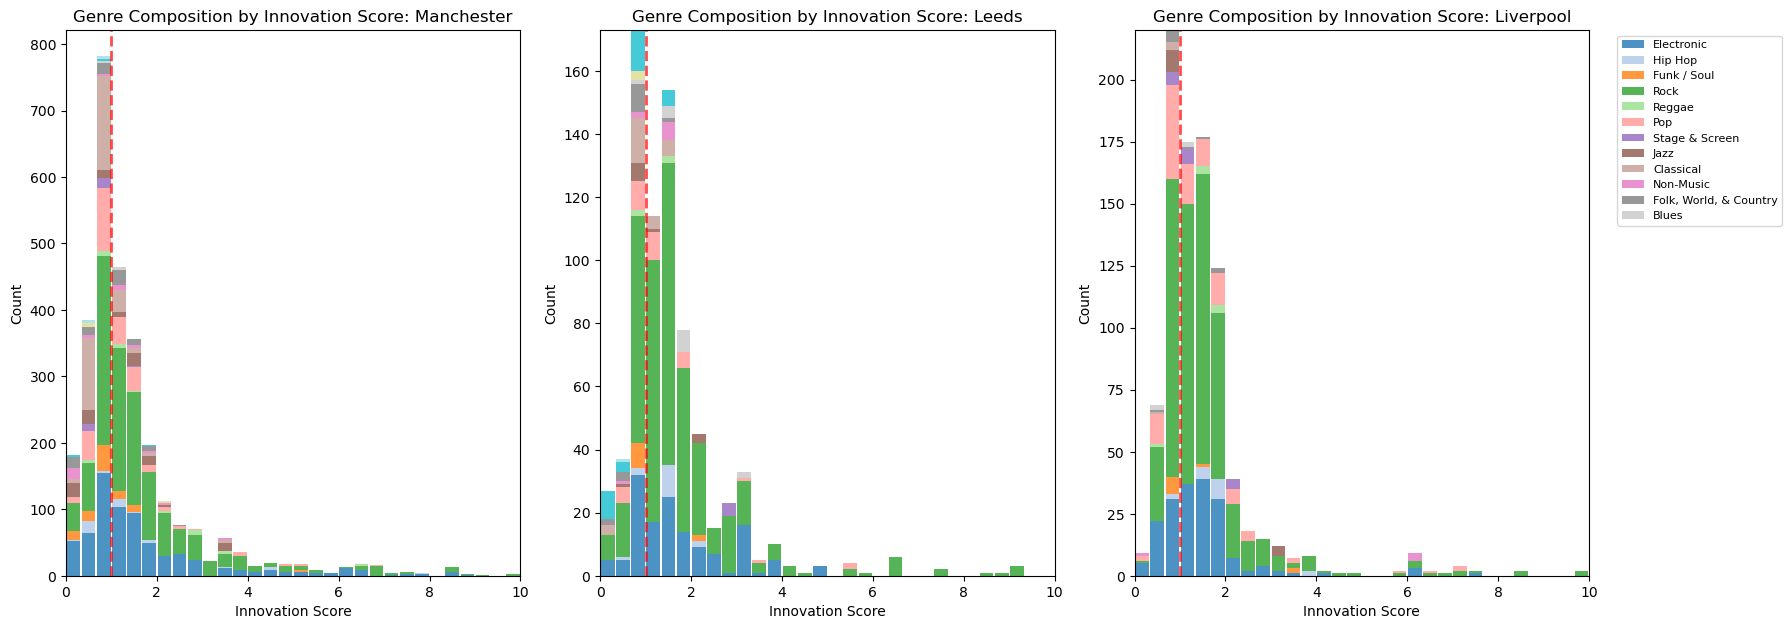

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#cities_to_plot = ['New York', 'London2', 'Manchester2', 'Nashville']

cities_to_plot = ['Manchester2', 'Leeds', 'Liverpool2']
#cities_to_plot = ['DÌùsseldorf', 'Edinburgh', 'Dortmund']

# Get unique genres and assign colors using a more distinguishable palette
unique_genres = df['genre'].dropna().unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_genres)))
genre_colors = dict(zip(unique_genres, colors))

plt.figure(figsize=(18, 12))
for i, city in enumerate(cities_to_plot, 1):
    city_data = df[(df['city'] == city) & (df['taddy'] != 99) & (df['genre'].notna())]
    
    plt.subplot(2, 3, i)
    
    # Create bins for taddy scores
    bins = np.linspace(0, 10, 31)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate histogram data for each genre
    genre_counts = {}
    for genre in unique_genres:
        genre_data = city_data[city_data['genre'] == genre]['taddy']
        counts, _ = np.histogram(genre_data, bins=bins)
        genre_counts[genre] = counts
    
    # Create stacked bar chart
    bottom = np.zeros(len(bin_centers))
    for genre in unique_genres:
        if genre_counts[genre].sum() > 0:  # Only plot genres with data
            plt.bar(bin_centers, genre_counts[genre], bottom=bottom, 
                   color=genre_colors[genre], alpha=0.8, width=0.3, label=genre)
            bottom += genre_counts[genre]
    
    # Use city_name for display
    city_display_name = df[df['city'] == city]['city_name'].iloc[0] if len(df[df['city'] == city]) > 0 else city
    plt.title(f'Genre Composition by Innovation Score: {city_display_name}')
    plt.xlabel('Innovation Score')
    plt.ylabel('Count')
    plt.xlim(0, 10)
    
    # Add red dashed line at innovation score of 1
    plt.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add legend only for first subplot
    if i == 3:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

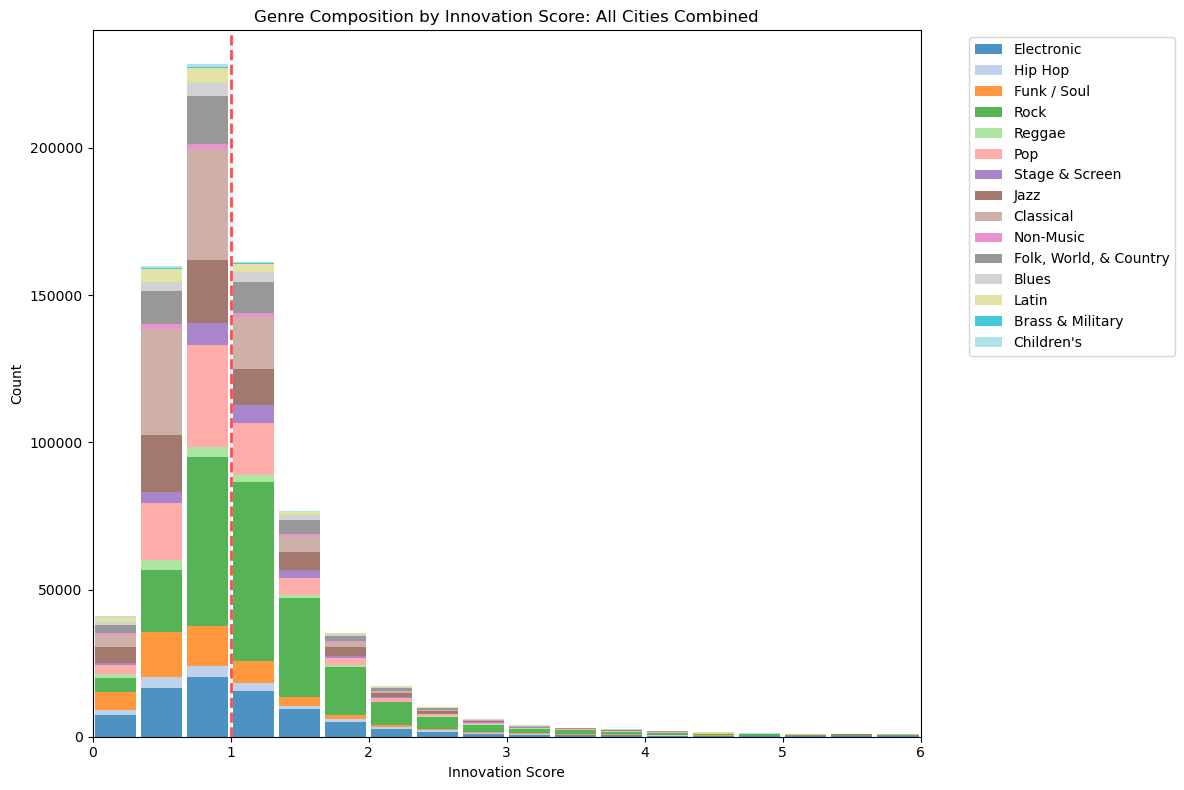

In [10]:
# Create genre composition histogram for all cities combined
plt.figure(figsize=(12, 8))

# Filter data for all cities with valid taddy scores and genres
all_cities_data = df[(df['taddy'] != 99) & (df['genre'].notna())]

# Create bins for taddy scores
bins = np.linspace(0, 10, 31)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histogram data for each genre
genre_counts = {}
for genre in unique_genres:
    genre_data = all_cities_data[all_cities_data['genre'] == genre]['taddy']
    counts, _ = np.histogram(genre_data, bins=bins)
    genre_counts[genre] = counts

# Get colors using a more distinguishable palette
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_genres)))
genre_colors = dict(zip(unique_genres, colors))

# Create stacked bar chart
bottom = np.zeros(len(bin_centers))
for genre in unique_genres:
    if genre_counts[genre].sum() > 0:  # Only plot genres with data
        plt.bar(bin_centers, genre_counts[genre], bottom=bottom, 
               color=genre_colors[genre], alpha=0.8, width=0.3, label=genre)
        bottom += genre_counts[genre]

plt.title('Genre Composition by Innovation Score: All Cities Combined')
plt.xlabel('Innovation Score')
plt.ylabel('Count')
plt.xlim(0, 6)

# Add red dashed line at innovation score of 1
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

Tab first release innovation scores

In [11]:
df = df.sort_values(['artist_id', 'year_x'])
df['first_release'] = df.groupby('artist_id')['year_x'].transform('rank') == 1

# Calculate average taddy scores by decade for first releases vs others
decades = range(1950, 2020, 10)
first_release_comparison = []

for decade_start in decades:
    decade_end = decade_start + 10
    decade_data = df[(df['year_x'] >= decade_start) & (df['year_x'] < decade_end) & (df['taddy'] != 99)]
    
    if len(decade_data) > 0:
        first_releases = decade_data[decade_data['first_release'] == True]['taddy']
        other_releases = decade_data[decade_data['first_release'] == False]['taddy']
        
        first_release_comparison.append({
            'decade': f'{decade_start}s',
            'first_release_innovation': first_releases.mean() if len(first_releases) > 0 else None,
            'later_release_innovation': other_releases.mean() if len(other_releases) > 0 else None,
            'first_release_count': len(first_releases),
            'later_release_count': len(other_releases)
        })

# Print comparison results
print("Average Taddy Scores by Decade: First Releases vs Others")
print("=" * 70)
for result in first_release_comparison:
    print(f"{result['decade']:>8s}: First={result['first_release_innovation']:.3f} (n={result['first_release_count']:>4d}), "
          f"Others={result['later_release_innovation']:.3f} (n={result['later_release_count']:>4d})")

Average Taddy Scores by Decade: First Releases vs Others
   1950s: First=1.405 (n= 588), Others=1.242 (n=9377)
   1960s: First=1.858 (n=1561), Others=1.629 (n=27417)
   1970s: First=1.753 (n=4382), Others=1.190 (n=103034)
   1980s: First=1.816 (n=6887), Others=1.189 (n=159931)
   1990s: First=1.711 (n=8321), Others=1.205 (n=196780)
   2000s: First=1.236 (n=5963), Others=1.085 (n=153014)
   2010s: First=1.295 (n=6617), Others=1.046 (n=134781)


In [12]:
# Calculate comprehensive style statistics
style_stats = []

for style in df['style'].dropna().unique():
    style_data = df[df['style'] == style]
    
    # Basic stats
    avg_taddy = style_data['taddy'].mean()
    first_year = style_data['year_x'].min()
    
    # Get city counts for this style
    city_counts = style_data['city'].value_counts()
    most_common_city = city_counts.index[0] if len(city_counts) > 0 else None
    second_common_city = city_counts.index[1] if len(city_counts) > 1 else None
    
    # Get early adopter cities (first 5 years)
    early_data = style_data[style_data['year_x'] <= first_year + 4]
    early_city_counts = early_data['city'].value_counts()
    early_top_city = early_city_counts.index[0] if len(early_city_counts) > 0 else None
    
    style_stats.append({
        'style': style,
        'taddy_avg': round(avg_taddy, 3) if pd.notna(avg_taddy) else None,
        'first_year': int(first_year) if pd.notna(first_year) else None,
        'most_common_city': most_common_city,
        'second_common_city': second_common_city,
        'early_top_city': early_top_city,
        'total_releases': len(style_data)
    })

# Create DataFrame and sort by average taddy score
style_analysis_df = pd.DataFrame(style_stats)
style_analysis_df = style_analysis_df.sort_values('taddy_avg', ascending=False).reset_index(drop=True)

# Save to explorations folder
output_path = r"data\explorations\style_innovation_analysis.csv"
style_analysis_df.to_csv(output_path, index=False)

print(f"Style analysis saved to: {output_path}")
print(f"\nTop 20 most innovative styles:")
print("=" * 80)

# Display results
pd.set_option('display.max_rows', None)
style_analysis_df.head(20)

Style analysis saved to: data\explorations\style_innovation_analysis.csv

Top 20 most innovative styles:


,style,taddy_avg,first_year,most_common_city,second_common_city,early_top_city,total_releases
0,Synthpunk,13.522,1977,New York,Los Angeles1,New York,4
1,Bleep,6.397,1990,London2,Manchester2,London2,31
2,Midwest Emo,6.165,1995,Chicago,Urbana,Urbana,6
3,Hard Beat,5.913,1989,None,None,None,3
4,Blackgaze,5.832,2011,San Jose3,San Mateo,Montreal,23
5,Acid House,5.559,0,London2,Sheffield,London2,212
6,New Beat,4.405,1986,Brussels,London2,Brussels,88
7,Britcore,4.185,1992,London2,Berlin,London2,6
8,Cloud Rap,4.113,2008,London2,Los Angeles1,Minneapolis,29
9,Bitpop,4.014,2013,New York,Stamford,New York,4


In [13]:
import pandas as pd

# Define the 10-year periods starting every 5 years
periods = []
for start_year in range(1950, 2016, 5):
    end_year = start_year + 10
    periods.append((start_year, end_year))

# Get list of cities with sufficient data
city_counts = df.groupby('city')['master_id'].nunique()
cities_with_data = city_counts[city_counts >= 100].index.tolist()

# Get all unique genres to create columns
all_genres = df['genre'].dropna().unique()

# Initialize list to store results
results = []

# Calculate averages for each city and period
for start_year, end_year in periods:
    period_data = df[(df['year_x'] >= start_year) & (df['year_x'] < end_year)]
    
    for city in cities_with_data:
        city_period_data = period_data[period_data['city'] == city]
        
        if len(city_period_data) >= 10:  # Only include if enough data points
            avg_forward = city_period_data['forward'].mean()
            avg_backward = city_period_data['backward'].mean()
            avg_taddy = city_period_data['taddy'].mean()
            
            # Calculate taddy percentiles
            taddy_p75 = city_period_data['taddy'].quantile(0.75) if city_period_data['taddy'].notna().sum() > 0 else None
            taddy_p90 = city_period_data['taddy'].quantile(0.90) if city_period_data['taddy'].notna().sum() > 0 else None
            taddy_p95 = city_period_data['taddy'].quantile(0.95) if city_period_data['taddy'].notna().sum() > 0 else None
            
            # Add average first release taddy score
            first_release_data = city_period_data[city_period_data['first_release'] == True]
            avg_first_release = first_release_data['taddy'].mean() if len(first_release_data) > 0 else None

            # Get genre counts for this city and period
            genre_counts = city_period_data['genre'].value_counts().to_dict()
            total_masters = len(city_period_data)
            
            # Calculate average taddy scores for each genre in this period/city
            genre_taddy_avgs = {}
            for genre in all_genres:
                genre_data = city_period_data[city_period_data['genre'] == genre]
                if len(genre_data) > 0:
                    genre_taddy_avgs[f'{genre}_avg_taddy'] = genre_data['taddy'].mean()
                else:
                    genre_taddy_avgs[f'{genre}_avg_taddy'] = None
            
            # Create the base result dictionary
            result = {
                'city': city,
                'period': f'{start_year}-{end_year}',
                'avg_forward': round(avg_forward, 3) if pd.notna(avg_forward) else None,
                'avg_backward': round(avg_backward, 3) if pd.notna(avg_backward) else None,
                'avg_taddy': round(avg_taddy, 3) if pd.notna(avg_taddy) else None,
                'taddy_p75': round(taddy_p75, 3) if pd.notna(taddy_p75) else None,
                'taddy_p90': round(taddy_p90, 3) if pd.notna(taddy_p90) else None,
                'taddy_p95': round(taddy_p95, 3) if pd.notna(taddy_p95) else None,
                'avg_first_release': round(avg_first_release, 3) if pd.notna(avg_first_release) else None,
                'count': len(city_period_data)
            }
            
            # Add each genre as count and share columns, plus average taddy
            for genre in all_genres:
                count = genre_counts.get(genre, 0)
                share = count / total_masters if total_masters > 0 else 0
                result[f'{genre}_total'] = count
                result[f'{genre}_share'] = round(share, 4)
            
            # Add genre taddy averages
            result.update(genre_taddy_avgs)
            
            results.append(result)

# Create DataFrame and pivot for better visualization
results_df = pd.DataFrame(results)

# Set display options for full output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display the results
print("Average Scores by City and Period:")
print("=" * 80)
results_df.head(50)  # Show first 50 rows, then can scroll through all

Average Scores by City and Period:


,city,period,avg_forward,avg_backward,avg_taddy,taddy_p75,taddy_p90,taddy_p95,avg_first_release,count,Electronic_total,Electronic_share,Hip Hop_total,Hip Hop_share,Jazz_total,Jazz_share,Funk / Soul_total,Funk / Soul_share,Classical_total,Classical_share,Latin_total,Latin_share,Pop_total,Pop_share,Reggae_total,Reggae_share,"Folk, World, & Country_total","Folk, World, & Country_share",Rock_total,Rock_share,Stage & Screen_total,Stage & Screen_share,Blues_total,Blues_share,Non-Music_total,Non-Music_share,Children's_total,Children's_share,Brass & Military_total,Brass & Military_share,Electronic_avg_taddy,Hip Hop_avg_taddy,Jazz_avg_taddy,Funk / Soul_avg_taddy,Classical_avg_taddy,Latin_avg_taddy,Pop_avg_taddy,Reggae_avg_taddy,"Folk, World, & Country_avg_taddy",Rock_avg_taddy,Stage & Screen_avg_taddy,Blues_avg_taddy,Non-Music_avg_taddy,Children's_avg_taddy,Brass & Military_avg_taddy
0,Amsterdam,1950-1960,0.066,0.123,0.678,0.935,1.284,1.284,1.059,80,0,0.0000,0,0.0,8,0.1000,0,0.0000,72,0.9000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,0.418863,NaN,0.707144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Atlanta,1950-1960,0.028,0.043,0.646,0.646,0.646,0.646,NaN,12,0,0.0000,0,0.0,0,0.0000,0,0.0000,6,0.5000,0,0.0000,0,0.0000,0,0.0000,6,0.5000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,NaN,NaN,0.645927,NaN,NaN,NaN,0.645927,NaN,NaN,NaN,NaN,NaN,NaN
2,Berkeley,1950-1960,0.019,0.014,5.407,9.690,9.690,9.690,NaN,18,0,0.0000,0,0.0,5,0.2778,0,0.0000,2,0.1111,5,0.2778,0,0.0000,0,0.0000,2,0.1111,0,0.0000,0,0.0000,2,0.1111,2,0.1111,0,0.0000,0,0.0000,NaN,NaN,7.849926,NaN,0.799864,7.849926,NaN,NaN,3.673562,NaN,NaN,3.673562,1.267307,NaN,NaN
3,Berlin,1950-1960,0.065,0.128,0.686,0.708,1.150,1.150,1.036,408,0,0.0000,0,0.0,6,0.0147,0,0.0000,372,0.9118,3,0.0074,9,0.0221,0,0.0000,0,0.0000,6,0.0147,6,0.0147,6,0.0147,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,1.150298,NaN,0.631387,1.738560,1.346385,NaN,NaN,1.150298,1.150298,1.150298,NaN,NaN,NaN
4,Boston,1950-1960,0.061,0.126,0.696,0.662,1.066,1.422,1.823,531,0,0.0000,0,0.0,19,0.0358,0,0.0000,388,0.7307,10,0.0188,39,0.0734,0,0.0000,0,0.0000,0,0.0000,52,0.0979,1,0.0019,2,0.0038,4,0.0075,16,0.0301,NaN,NaN,1.015991,NaN,0.646437,0.836259,0.766231,NaN,NaN,NaN,0.691525,4.414214,4.710437,0.600354,0.554743
5,Bradford,1950-1960,0.036,0.039,0.913,0.913,0.913,0.913,NaN,14,0,0.0000,0,0.0,0,0.0000,0,0.0000,14,1.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,NaN,NaN,0.913335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Brussels,1950-1960,0.032,0.013,6.803,9.035,9.035,13.579,0.674,15,0,0.0000,0,0.0,0,0.0000,0,0.0000,6,0.4000,0,0.0000,5,0.3333,0,0.0000,0,0.0000,4,0.2667,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,NaN,NaN,0.929532,NaN,12.064392,NaN,NaN,9.034723,NaN,NaN,NaN,NaN,NaN
7,Chicago,1950-1960,0.028,0.035,2.081,2.248,3.680,6.152,3.823,161,0,0.0000,0,0.0,78,0.4845,3,0.0186,4,0.0248,3,0.0186,20,0.1242,1,0.0062,13,0.0807,11,0.0683,0,0.0000,22,0.1366,6,0.0373,0,0.0000,0,0.0000,NaN,NaN,1.647268,1.741540,0.818655,1.217962,1.745341,2.716884,1.131012,2.479482,NaN,4.215257,3.680395,NaN,NaN
8,Cincinnati,1950-1960,0.039,0.048,1.406,1.536,3.304,3.513,0.227,34,0,0.0000,0,0.0,5,0.1471,11,0.3235,6,0.1765,0,0.0000,0,0.0000,0,0.0000,4,0.1176,3,0.0882,0,0.0000,5,0.1471,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,1.028844,1.930795,0.562941,NaN,NaN,NaN,0.360349,1.962819,NaN,2.143309,NaN,NaN,NaN
9,Covington,1950-1960,0.047,0.073,1.079,1.536,1.536,1.792,NaN,17,0,0.0000,0,0.0,2,0.1176,5,0.2941,6,0.3529,0,0.0000,0,0.0000,0,0.0000,0,0.0000,3,0.1765,0,0.0000,1,0.0588,0,0.0000,0,0.0000,0,0.0000,NaN,NaN,1.216793,1.128758,0.562941,NaN,NaN,NaN,NaN,1.962819,NaN,0.991668,NaN,NaN,NaN


In [15]:
city_stats = pd.read_csv(STATS_PATH)
city_stats.columns
#city_stats['city'] = city_stats['city'].apply(clean_city_name)

Index(['Unnamed: 0', 'city', 'genre', 'style', 'start_year', 'end_year',
       'num_releases', 'num_master_ids', 'releases_per_master_mean',
       'releases_per_master_median', 'releases_per_master_10th',
       'releases_per_master_25th', 'releases_per_master_75th',
       'releases_per_master_90th', 'num_nodes', 'num_edges', 'density',
       'components', 'largest_cc_size', 'avg_degree', 'max_degree',
       'min_degree', 'entropy'],
      dtype='object')

In [16]:
# Load city_stats dataframe and merge with results_df


# Create period column in city_stats to match results_df format
city_stats['period'] = city_stats['start_year'].astype(str) + '-' + city_stats['end_year'].astype(str)

# Merge the dataframes on city and period - ensure est_2010_population is preserved
merged_stats = pd.merge(city_stats, results_df, on=['city', 'period'], how='outer')

# Display the merged dataframe
print("Merged City Stats with Innovation Scores:")
print("=" * 80)
merged_stats.sample(20)

Merged City Stats with Innovation Scores:


,Unnamed: 0,city,genre,style,start_year,end_year,num_releases,num_master_ids,releases_per_master_mean,releases_per_master_median,releases_per_master_10th,releases_per_master_25th,releases_per_master_75th,releases_per_master_90th,num_nodes,num_edges,density,components,largest_cc_size,avg_degree,max_degree,min_degree,entropy,period,avg_forward,avg_backward,avg_taddy,taddy_p75,taddy_p90,taddy_p95,avg_first_release,count,Electronic_total,Electronic_share,Hip Hop_total,Hip Hop_share,Jazz_total,Jazz_share,Funk / Soul_total,Funk / Soul_share,Classical_total,Classical_share,Latin_total,Latin_share,Pop_total,Pop_share,Reggae_total,Reggae_share,"Folk, World, & Country_total","Folk, World, & Country_share",Rock_total,Rock_share,Stage & Screen_total,Stage & Screen_share,Blues_total,Blues_share,Non-Music_total,Non-Music_share,Children's_total,Children's_share,Brass & Military_total,Brass & Military_share,Electronic_avg_taddy,Hip Hop_avg_taddy,Jazz_avg_taddy,Funk / Soul_avg_taddy,Classical_avg_taddy,Latin_avg_taddy,Pop_avg_taddy,Reggae_avg_taddy,"Folk, World, & Country_avg_taddy",Rock_avg_taddy,Stage & Screen_avg_taddy,Blues_avg_taddy,Non-Music_avg_taddy,Children's_avg_taddy,Brass & Military_avg_taddy
9581,NaN,San Diego,NaN,NaN,1965.0,1975.0,11.0,5.0,2.200000,2.0,2.0,2.00,2.0,2.6,95.0,1419.0,0.317805,5.0,46.0,29.873684,45.0,7.0,6.329451,1965-1975,0.016,0.029,0.670,0.711,1.145,1.145,NaN,13.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,4.0,0.3077,0.0,0.0000,1.0,0.0769,8.0,0.6154,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.710818,NaN,0.570110,0.661406,NaN,NaN,NaN,NaN,NaN
1652,101.0,Chicago,NaN,NaN,1965.0,1975.0,911.0,291.0,3.130584,2.0,1.0,1.00,4.0,6.0,2800.0,53134.0,0.013559,12.0,2693.0,37.952857,437.0,1.0,10.968698,1965-1975,0.030,0.029,1.590,1.519,2.620,3.836,2.482,1232.0,8.0,0.0065,0.0,0.0000,277.0,0.2248,357.0,0.2898,2.0,0.0016,1.0,0.0008,78.0,0.0633,0.0,0.0000,51.0,0.0414,230.0,0.1867,17.0,0.0138,202.0,0.1640,9.0,0.0073,0.0,0.0000,0.0,0.0000,1.792456,NaN,1.415640,1.792158,5.135652,2.216240,1.432139,NaN,1.080677,2.075235,0.838239,1.143442,1.246007,NaN,NaN
587,NaN,Berkeley,NaN,NaN,2005.0,2015.0,209.0,69.0,3.028986,2.0,1.0,1.00,4.0,6.0,926.0,15803.0,0.036899,23.0,288.0,34.131749,98.0,2.0,9.393545,2005-2015,0.030,0.028,1.251,1.649,2.048,2.368,NaN,425.0,33.0,0.0776,3.0,0.0071,88.0,0.2071,11.0,0.0259,4.0,0.0094,10.0,0.0235,23.0,0.0541,2.0,0.0047,25.0,0.0588,209.0,0.4918,9.0,0.0212,6.0,0.0141,0.0,0.0000,2.0,0.0047,0.0,0.0000,1.273659,0.380176,1.440983,1.350201,1.148152,1.051316,0.963819,1.207107,1.166643,1.255921,0.907932,1.022851,NaN,0.538854,NaN
4222,10.0,London2,NaN,NaN,2000.0,2010.0,15202.0,2793.0,5.442893,3.0,1.0,2.00,6.0,12.0,38076.0,1915623.0,0.002643,54.0,37376.0,100.621021,5205.0,1.0,14.384803,2000-2010,0.024,0.024,1.005,1.221,1.546,1.821,1.129,17398.0,3155.0,0.1813,347.0,0.0199,785.0,0.0451,586.0,0.0337,3603.0,0.2071,128.0,0.0074,2065.0,0.1187,187.0,0.0107,589.0,0.0339,4492.0,0.2582,1014.0,0.0583,216.0,0.0124,184.0,0.0106,22.0,0.0013,25.0,0.0014,0.938937,0.767066,1.156192,0.896897,0.744960,0.973744,0.949994,0.934789,1.142098,1.253481,0.989760,1.243177,1.425542,1.071985,0.838422
8097,51.0,Paris,NaN,NaN,1995.0,2005.0,4591.0,1022.0,4.492172,2.0,1.0,1.00,4.0,9.0,14443.0,460127.0,0.004412,42.0,14036.0,63.716264,1151.0,1.0,13.244902,1995-2005,0.016,0.017,0.934,1.121,1.417,1.680,1.058,5151.0,623.0,0.1209,339.0,0.0658,453.0,0.0879,138.0,0.0268,763.0,0.1481,217.0,0.0421,966.0,0.1875,100.0,0.0194,577.0,0.1120,685.0,0.1330,220.0,0.0427,21.0,0.0041,36.0,0.0070,10.0,0.0019,3.0,0.0006,1.000217,1.080191,0.968818,0.962009,0.747398,0.710685,0.947805,0.806199,0.717259,1.236467,0.953508,0.941133,0.788422,0.792925,1.084737
227,395.0,Atlanta,NaN,NaN,1965.0,1975.0,10.0,5.0,2.000000,2.0,1.0,1.00,2.0,3.2,73.0,707.0,0.269026,3.0,36.0,19.369863,35.0,16.0,6.157914,1965-1975,0.042,0.035,1.570,1.745,2.777,3.264,1.534,91.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,45.0,0.4945,0.0,0.0000,0.0,0.0000,2.0,0.0220,0.0,0.

In [17]:
# Calculate HHI for genres and styles for each city and period
def calculate_hhi(counts_dict):
    """Calculate Herfindahl-Hirschman Index from counts dictionary"""
    if not counts_dict or sum(counts_dict.values()) == 0:
        return None
    
    total = sum(counts_dict.values())
    shares = [count/total for count in counts_dict.values()]
    hhi = sum([share**2 for share in shares])
    return round(hhi, 4)

# Add HHI calculations to results_df
results_df_with_hhi = results_df.copy()

# Calculate genre HHI from existing genre columns
genre_columns = [col for col in results_df.columns if col.endswith('_total')]
results_df_with_hhi['genre_hhi'] = results_df[genre_columns].apply(
    lambda row: calculate_hhi({col.replace('_total', ''): val for col, val in row.items() if val > 0}), 
    axis=1
)

# Calculate style HHI from main table
style_hhi_list = []
for _, row in results_df.iterrows():
    city = row['city']
    period = row['period']
    start_year, end_year = map(int, period.split('-'))
    
    # Get style counts for this city and period
    city_period_data = df[(df['city'] == city) & 
                         (df['year_x'] >= start_year) & 
                         (df['year_x'] < end_year)]
    
    if len(city_period_data) > 0:
        style_counts = city_period_data['style'].value_counts().to_dict()
        style_hhi = calculate_hhi(style_counts)
    else:
        style_hhi = None
    
    style_hhi_list.append(style_hhi)

results_df_with_hhi['style_hhi'] = style_hhi_list

# Display results with HHI
print("Results with Genre and Style HHI:")
print("=" * 80)
results_df_with_hhi[['city', 'period', 'genre_hhi', 'style_hhi', 'avg_taddy']].head(20)

Results with Genre and Style HHI:


,city,period,genre_hhi,style_hhi,avg_taddy
0,Amsterdam,1950-1960,0.8200,0.2650,0.678
1,Atlanta,1950-1960,0.5000,0.3333,0.646
2,Berkeley,1950-1960,0.2037,0.1049,5.407
3,Berlin,1950-1960,0.8327,0.1814,0.686
4,Boston,1950-1960,0.5515,0.1500,0.696
5,Bradford,1950-1960,1.0000,0.5000,0.913
6,Brussels,1950-1960,0.3422,0.2267,6.803
7,Chicago,1950-1960,0.2827,0.0611,2.081
8,Cincinnati,1950-1960,0.2007,0.1730,1.406
9,Covington,1950-1960,0.2595,0.1972,1.079


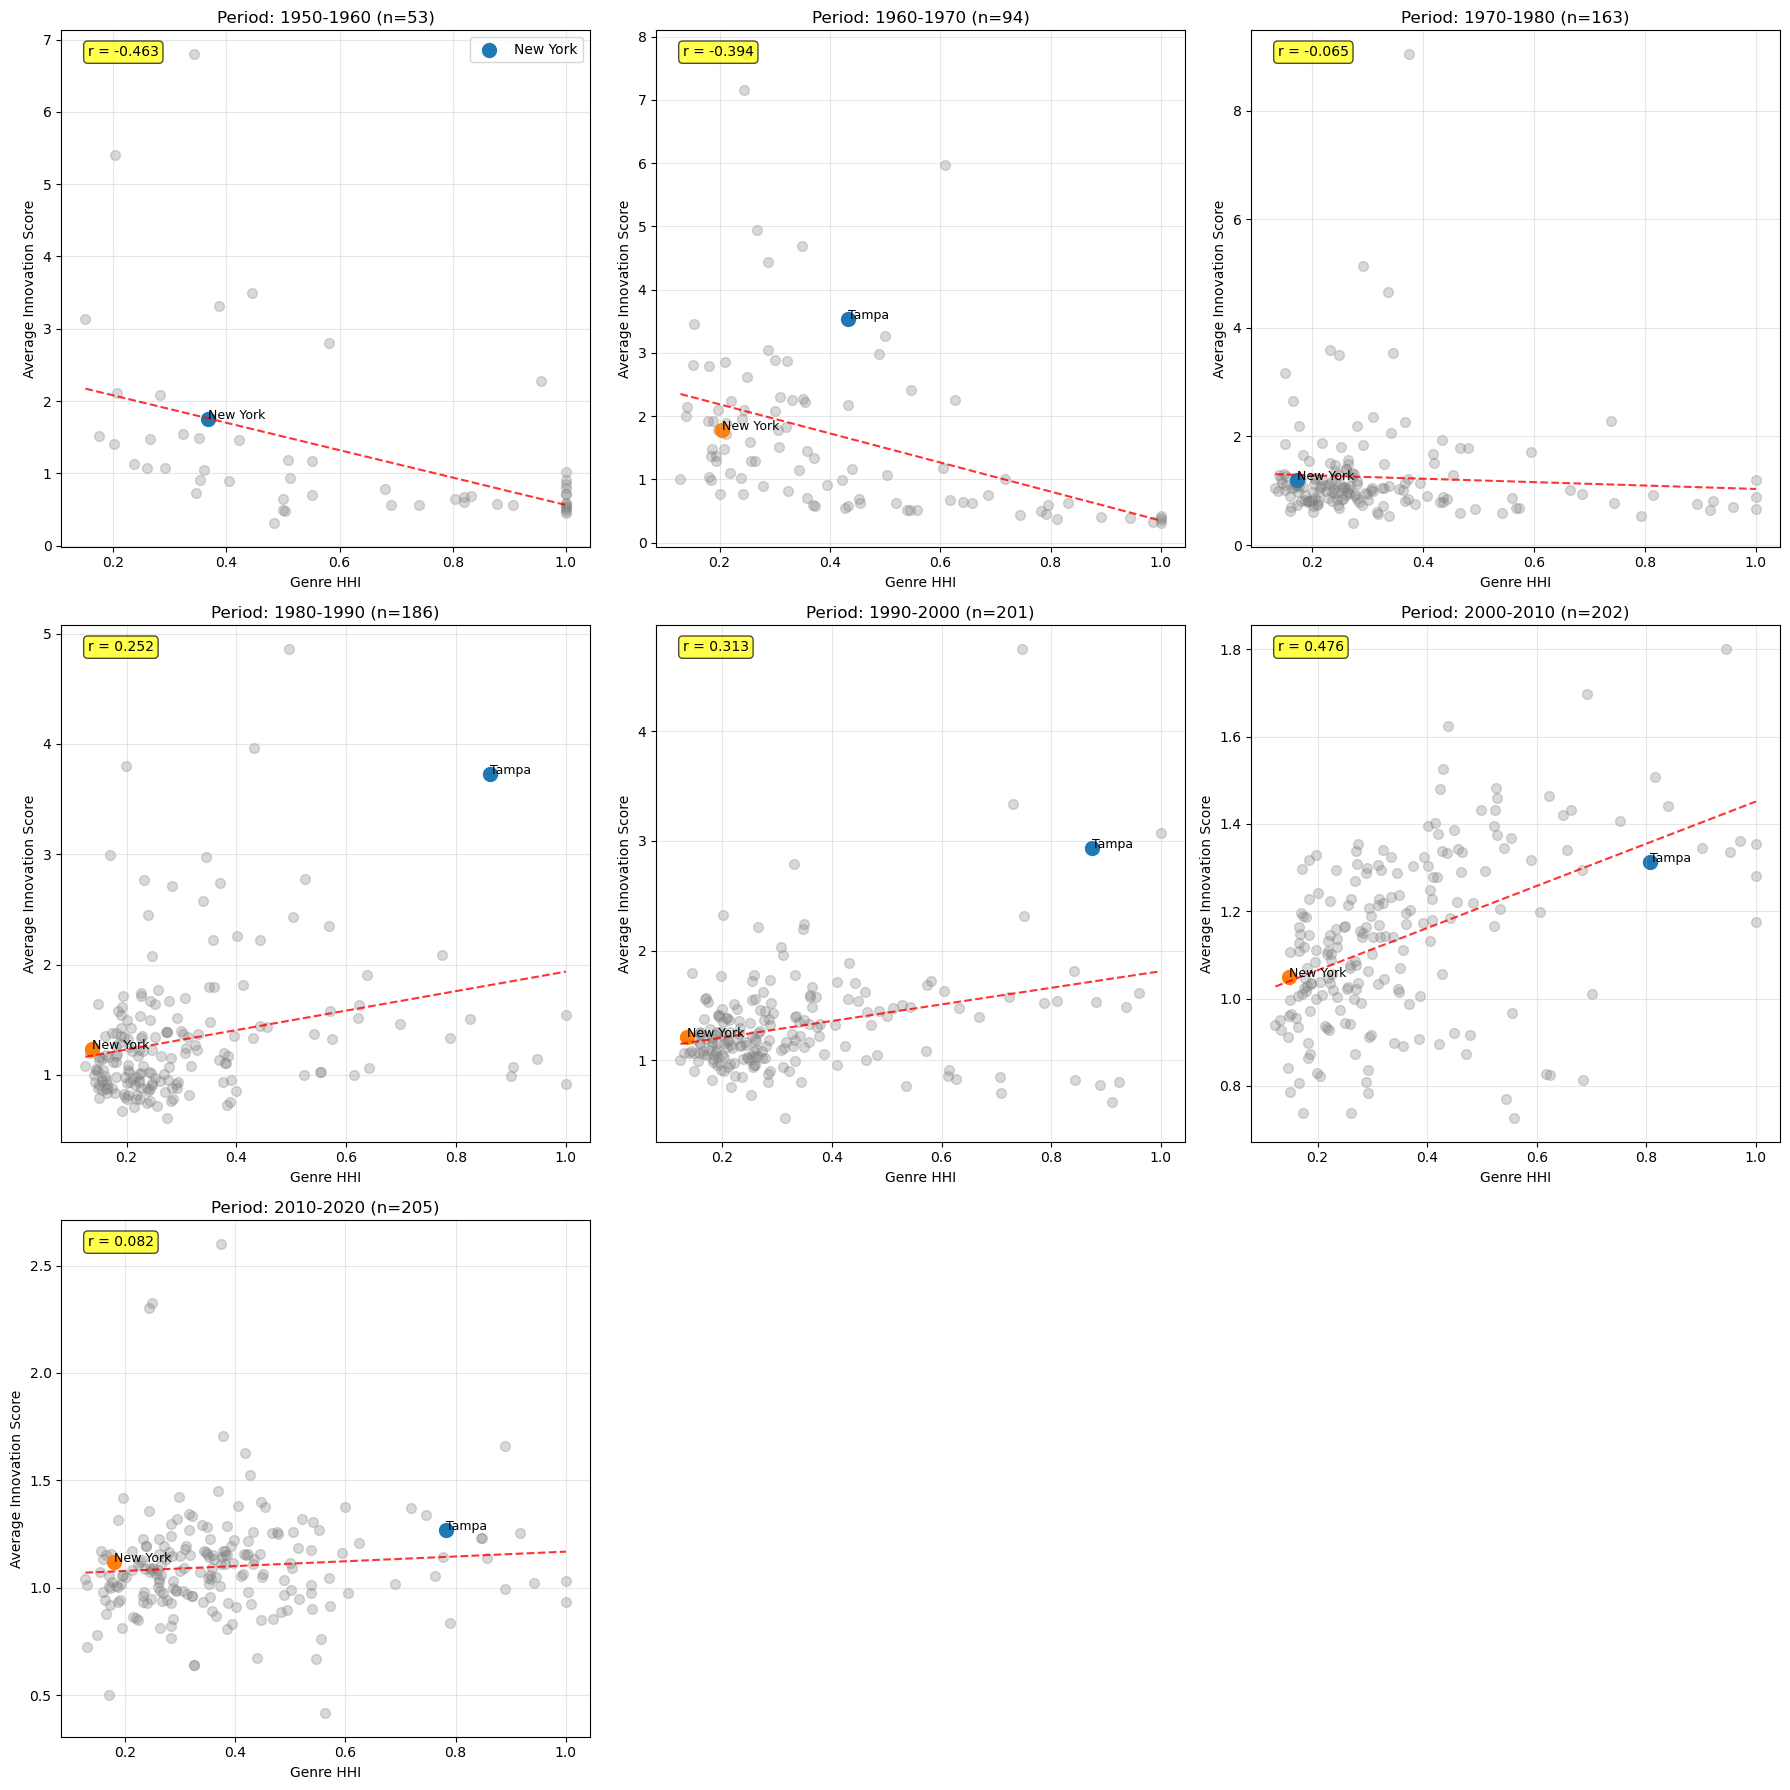

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cities_to_label = ["Manchester2", "Tampa", "London2", "New York"]

# Get unique periods and filter for decade start years only
all_periods = results_df_with_hhi['period'].dropna().unique()
periods = [p for p in all_periods if int(p.split('-')[0]) % 10 == 0]

# Calculate subplot grid dimensions
n_periods = len(periods)
cols = 3
rows = (n_periods + cols - 1) // cols

# Create scatterplots for each period using genre HHI
plt.figure(figsize=(18, 6 * rows))

for i, period in enumerate(sorted(periods), 1):
    # Filter data for this period
    period_data = results_df_with_hhi[
        (results_df_with_hhi['period'] == period) & 
        results_df_with_hhi['avg_taddy'].notna() & 
        results_df_with_hhi['genre_hhi'].notna()
    ]
    
    plt.subplot(rows, cols, i)
    
    if len(period_data) > 0:
        # Plot all cities
        plt.scatter(period_data['genre_hhi'], period_data['avg_taddy'], alpha=0.3, s=50, color='gray')
        
        # Highlight and label specific cities
        for city in cities_to_label:
            city_data = period_data[period_data['city'] == city]
            if not city_data.empty:
                plt.scatter(city_data['genre_hhi'], city_data['avg_taddy'], s=100, label=city)
#                # Remove numbers from city name for display
                display_city = re.sub(r'\d+$', '', city)
                plt.text(city_data['genre_hhi'].iloc[0], city_data['avg_taddy'].iloc[0], display_city, fontsize=9)

        # Add trendline for all data in the period
        if len(period_data) > 1:
            z = np.polyfit(period_data['genre_hhi'], period_data['avg_taddy'], 1)
            p = np.poly1d(z)
            plt.plot(period_data['genre_hhi'].sort_values(), p(period_data['genre_hhi'].sort_values()), "r--", alpha=0.8)
            
            # Add correlation coefficient for this period
            correlation = period_data['avg_taddy'].corr(period_data['genre_hhi'])
            plt.text(0.05, 0.95, f'r = {correlation:.3f}', transform=plt.gca().transAxes, 
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.xlabel('Genre HHI')
    plt.ylabel('Average Innovation Score')
    plt.title(f'Period: {period} (n={len(period_data)})')
    plt.grid(True, alpha=0.3)
    
    # Add legend to the first plot
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Calculate master_id count for each city
city_master_counts = df.groupby('city')['master_id'].nunique().reset_index()
city_master_counts.rename(columns={'master_id': 'master_id_count'}, inplace=True)

# Get cities with more than 300 master_ids
cities_with_sufficient_data = city_master_counts[city_master_counts['master_id_count'] > 300]['city']

# Filter the main dataframe to only include these cities
filtered_df = df[df['city'].isin(cities_with_sufficient_data)]

# Calculate average taddy score for each city (excluding taddy=99)
city_avg_taddy = filtered_df[filtered_df['taddy'] != 99].groupby('city')['taddy'].mean().reset_index()
city_avg_taddy.rename(columns={'taddy': 'city_avg_taddy_score'}, inplace=True)
innovative_albums = filtered_df[filtered_df['taddy'] != 99].sort_values('taddy', ascending=False)
top_5_albums_per_city = innovative_albums.groupby('city').head(10)
top_albums_df = top_5_albums_per_city[['city', 'title', 'artist_name', 'taddy', 'style']].copy()
top_albums_df.rename(columns={'taddy': 'album_taddy_score'}, inplace=True)
top_albums_df = pd.merge(top_albums_df, city_avg_taddy, on='city', how='left')
top_albums_df = pd.merge(top_albums_df, city_master_counts, on='city', how='left')
top_albums_df = top_albums_df[['city', 'master_id_count', 'city_avg_taddy_score', 'title', 'artist_name', 'album_taddy_score', 'style']]


# Define output path and save to CSV
output_path = r"data\explorations\top_5_innovative_albums_per_city.csv"
top_albums_df.to_csv(output_path, index=False)

print(f"Top 5 innovative albums per city saved to: {output_path}")
top_albums_df.head(10)

Top 5 innovative albums per city saved to: data\explorations\top_5_innovative_albums_per_city.csv


,city,master_id_count,city_avg_taddy_score,title,artist_name,album_taddy_score,style
0,London2,27724,1.239135,Our Aim Is True,Elvis Costello,284.761261,New Wave
1,London2,27724,1.239135,Our Aim Is True,Elvis Costello,284.761261,Punk
2,Nashville,5214,1.020694,Blonde On Blonde,Bob Dylan,265.785767,Folk Rock
3,Nashville,5214,1.020694,Blonde On Blonde,Bob Dylan,265.785767,Blues Rock
4,Paris,8622,1.048373,Liberty,Les Enfants De Dieu,206.994217,Disco
5,New York,24269,1.245124,Blondie,Blondie,189.758362,Punk
6,New York,24269,1.245124,Blondie,Blondie,189.758362,New Wave
7,New York,24269,1.245124,Blondie,Blondie,189.758362,Punk
8,New York,24269,1.245124,Blondie,Blondie,189.758362,New Wave
9,London2,27724,1.239135,Live In London At The Roundhouse In May 1976,Patti Smith,188.731033,Punk


In [20]:
df.columns

Index(['master_id', 'artist_id', 'genre', 'style', 'data_quality_y', 'year_x',
       'title', 'recorded_id', 'latitude', 'longitude', 'geocoding_method',
       'geometry', 'city', 'est_2010_population', 'max_bb_xma', 'count',
       'member_ids', 'artist_name', 'artist_info_data_quality', 'new_style_1',
       'novel_style_combo_count', 'year_y', 'forward', 'backward', 'taddy',
       'city_name', 'first_release'],
      dtype='object')

In [21]:
centralities = pd.read_csv(CENTRALITIES_PATH)

centralities.rename(columns={"betweenness_centrality": "centrality"}, inplace=True)

centralities['period'] = centralities['year_range'].str.replace('_', '-')

city_population = df.groupby('city')['est_2010_population'].first().reset_index()

final_panel = merged_stats.copy()
hhi_mapping = results_df_with_hhi[['city', 'period', 'genre_hhi', 'style_hhi']].copy()

final_panel = pd.merge(final_panel, hhi_mapping, on=['city', 'period'], how='left')
final_panel = pd.merge(final_panel, centralities, on=['city', 'period'], how='left')
final_panel = pd.merge(final_panel, city_population, on='city', how='left')

# Verify est_2010_population is preserved in final panel
if 'est_2010_population' in final_panel.columns:
    print("est_2010_population successfully preserved in final panel dataset")
else:
    print("Warning: est_2010_population missing from final panel dataset")

CSV_OUTPUT = r"data\city_panel.csv"
DTA_OUTPUT = r"data\city_panel.dta"

final_panel.to_csv(CSV_OUTPUT, index=False)
print(f"saved to CSV: {CSV_OUTPUT}")

final_panel.to_stata(DTA_OUTPUT, write_index=False)
print(f"saved to DTA: {DTA_OUTPUT}")
final_panel.sample(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\total_centrality.csv'